In [1]:
import importlib

import dataset, metrics, plotting, config
from models import reg_cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)

Using TensorFlow backend.


<module 'models.reg_cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/RegCGAN/models/reg_cgan_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="magical_sinus", n_instance=250)

assert(dataset_config.scenario == "magical_sinus"
       or dataset_config.scenario == "hdpe"
      )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/magical_sinus already exists replacing files in this notebook


In [3]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.001, optim_gen="Adam",
                             optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_sampling=500),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [4]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [5]:
X_train, y_train, X_valid, y_valid = dataset.get_dataset(exp_config.dataset.n_instance,
                                                                         exp_config.dataset.scenario)

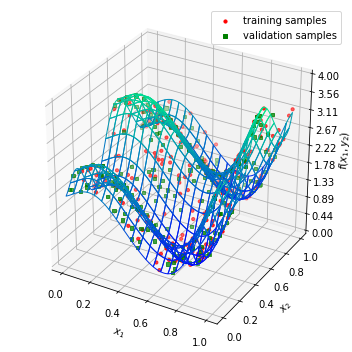

In [6]:
%matplotlib inline 
plotting.plot_dataset(X_train, X_valid, y_train, y_valid, exp_config, fig_dir)

## Finding sparse regions using Local Outlier Factor (LOF)

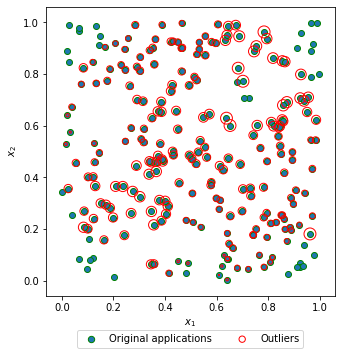

In [7]:
from sklearn.neighbors import LocalOutlierFactor


X = X_train
clf = LocalOutlierFactor(n_neighbors=240)
clf.fit(X)
X_scores = clf.negative_outlier_factor_
mean_scores = np.mean(X_scores)
mask = X_scores > mean_scores

X_outliers = X[mask]
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

if len(X_outliers):

    # plot the original data points where outliers are marked by cycles.
    # The more larger the circle, the more isolated the data points away from 
    # its neighbors.
    plotting.plot_sparse_regions(X, X_outliers, radius[mask], fig_dir)

## CVT sampling and discrepancy evaluating

In [ ]:

from idaes.surrogate.pysmo import sampling as sp
from diversipy import unanchored_L2_discrepancy

assert len(X_outliers) !=0, "No sparse regions in the input space has been found."

min_n_sampling, max_n_sampling, interval = 60, 260, 20

minimum, maximum = np.amin(X_outliers, axis=0).tolist(), np.amax(X_outliers, axis=0).tolist()
bounds = [minimum, maximum]

X_discrepancy = unanchored_L2_discrepancy(X_outliers)
X_CVT_discrepancy_list, X_full_discrepancy_list, CVT_dict = [], [], {}
i = 0
for n_sampling in range(min_n_sampling, max_n_sampling, interval):
    space_init = sp.CVTSampling(bounds, sampling_type="creation", number_of_samples=n_sampling)
    X_CVT = space_init.sample_points()
    CVT_dict[f"num_sampling_{n_sampling}"] = X_CVT
    X_CVT_discrepancy = unanchored_L2_discrepancy(X_CVT)
    X_CVT_discrepancy_list.append(X_CVT_discrepancy)

    X_full = np.r_[X, X_CVT]
    X_full_discrepancy = unanchored_L2_discrepancy(X_full)
    X_full_discrepancy_list.append(X_full_discrepancy)
    print(f"Discrepancy values: {X_discrepancy:.4f} for original data; "
          f"{X_CVT_discrepancy:.4f} for {n_sampling} CVT samples; "
          f"{X_full_discrepancy:4f} for full data.")

best_n_sampling = np.arange(min_n_sampling, max_n_sampling, interval)[np.argmin(np.array(X_full_discrepancy_list))]
best_CVT = CVT_dict[f"num_sampling_{best_n_sampling}"]
print(f"The  optimal value for n_sampling in CVT sampling is {best_n_sampling}")

Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0155 for 60 CVT samples; 0.007397 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0107 for 80 CVT samples; 0.006415 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0088 for 100 CVT samples; 0.006746 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0092 for 120 CVT samples; 0.006094 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0092 for 140 CVT samples; 0.005970 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0085 for 160 CVT samples; 0.005512 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0059 for 180 CVT samples; 0.005401 for full data.
Sampling type:  creation 

Discrepancy values: 0.0131 for original data; 0.0088 for 200 CVT samples; 0.006300 for full data.
Sa

In [ ]:
X_discrepancy = unanchored_L2_discrepancy(X_outliers)
plotting.plot_cvt_discrepancy(min_n_sampling, max_n_sampling, interval, X_full_discrepancy_list, fig_dir,
                              title=f"Baseline of discrepancy = {X_discrepancy:2.5f}")

In [ ]:
from scipy.spatial import Voronoi
from scipy.spatial import voronoi_plot_2d

sampling_key = f"num_sampling_{best_n_sampling}"
X_CVT = CVT_dict[sampling_key]

# plot CVT samples
plotting.plot_voronoi_cvt(X_outliers, X_CVT, Voronoi, voronoi_plot_2d, fig_dir)

# save CVT samples to .npy file
from os.path import basename
np.save(f"{fig_dir}/{basename(fig_dir)}_CVT_samples.npy", X_CVT)

## Gaussian Process 

In [ ]:
import GPy

noise = 4.3
length = 16

run_hyperopt_search = True

kernel = GPy.kern.RBF(input_dim=2, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)
if run_hyperopt_search:
    gpr.optimize(messages=True)
ypred_gp, cov = gpr.predict(X_valid)

## Construct RegCGAN model

In [ ]:
reg_cgan = reg_cgan_model.RegCGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = reg_cgan.train(X_train, y_train,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=False)

In [ ]:
ypred_reg_cgan = reg_cgan.predict(X_valid)

In [ ]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## Predictions

In [ ]:
# Predictions using single or mean of CGAN along with GP
plotting.plot_ypred_joint(X_valid, y_valid, ypred_single_cgan_valid, ypred_mean_cgan_valid, ypred_gp_valid,
                          fig_dir=fig_dir, prefix="single_mean_cgan_gp", save_fig=exp_config.run.save_fig,
                          alpha=0.5, elevation=30, azimuth=60)


In [ ]:
plotting.plot_ypred_error(y_valid, ypred_single_cgan_valid, ypred_mean_cgan_valid, ypred_gp_valid,
                          fig_dir=fig_dir, prefix="single_mean_cgan_gp", save_fig=exp_config.run.save_fig)

## Marginalized density of P(y) 

In [ ]:
plotting.plot_densities_joint(y_valid, ypred_single_cgan_valid, ypred_mean_cgan_valid, ypred_gp_valid,
                              title=r"Marginalized $P(y)$", fig_dir=fig_dir,
                              prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

## Sampling from P(y|x)

In [ ]:
num_sampling = 200 # increase sample_size to have gaussian densities for GP
_, _, X, y = dataset.get_dataset(exp_config.dataset.n_instance, exp_config.dataset.scenario)

ypred_mean_cgan, _, ypred_mean_cgan_sampling = cgan.sample(X, num_sampling)

ypred_gp, cov = gpr.predict(X)
ypred_gp_sampling = np.random.normal(ypred_gp, np.sqrt(cov))
for i in range(1, num_sampling):
    ypred_gp_sampling = np.hstack([ypred_gp_sampling, np.random.normal(ypred_gp, np.sqrt(cov))])
    
ypred_single_cgan_sampling = cgan.predict(X)
for i in range(1, num_sampling):
    ypred_single_cgan_sampling = np.hstack([ypred_single_cgan_sampling, cgan.predict(X)])


In [ ]:
bins =[[0.91, 0.36], [0.29, 0.47], [0.63, 0.53]]
for (x1, x2) in bins:
    y_true = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (num_sampling, 1)),
                                        y=np.tile(y, (num_sampling, 1)))
    
    ypred_single_cgan_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (num_sampling, 1)),
                                        y=np.ravel(ypred_single_cgan_sampling.T).reshape(-1, 1))
    
    ypred_mean_cgan_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (num_sampling, 1)),
                                        y=np.ravel(ypred_mean_cgan_sampling.T).reshape(-1, 1))

    ypred_gp_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X, (num_sampling, 1)),
                                        y=np.ravel(ypred_gp_sampling.T).reshape(-1, 1))

    (y_true, ypred_mean_cgan_cond, ypred_gp_cond) = (y_true.reshape(-1, 1),
                                                      ypred_mean_cgan_cond.reshape(-1, 1),
                                                      ypred_gp_cond.reshape(-1, 1))

    plotting.plot_densities_joint(y_true.reshape(-1,1), 
                                  ypred_single_cgan_cond.reshape(-1, 1), 
                                  ypred_mean_cgan_cond.reshape(-1, 1),
                                  ypred_gp_cond.reshape(-1, 1),
                                  title = f"conditional density of $P(y|x_1={x1},x_2={x2})$ ", fig_dir=fig_dir, 
                                  prefix=f"condition_density_P(y|x1={x1},x2={x2})", save_fig=exp_config.run.save_fig)


## Metrics on validation samples

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

single_cgan_mae_list = []
single_cgan_mse_list= []

mean_cgan_mae_list = []
mean_cgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 50
for i in range(n_eval_runs):
    ypred_single_cgan = cgan.predict(X_valid)
    single_cgan_mae_list.append(mean_absolute_error(y_valid, ypred_single_cgan))
    single_cgan_mse_list.append(mean_squared_error(y_valid, ypred_single_cgan))

    ypred_mean_cgan, _, _ = cgan.sample(X_valid, exp_config.training.n_samples)
    mean_cgan_mae_list.append(mean_absolute_error(y_valid, ypred_mean_cgan))
    mean_cgan_mse_list.append(mean_squared_error(y_valid, ypred_mean_cgan))

    yped_gp = np.random.normal(ypred_gp_valid, np.sqrt(cov_valid))
    gp_mae_list.append(mean_absolute_error(y_valid, yped_gp))
    gp_mse_list.append(mean_squared_error(y_valid, yped_gp))


In [ ]:
single_cgan_mae_mean, single_cgan_mae_std = np.mean(np.asarray(single_cgan_mae_list)), np.std(np.asarray(single_cgan_mae_list))
single_cgan_mse_mean, single_cgan_mse_std = np.mean(np.asarray(single_cgan_mse_list)), np.std(np.asarray(single_cgan_mse_list))

print(f"Single CGAN validation MAE: {single_cgan_mae_mean:.3f} +- {single_cgan_mae_std:.5f}")
print(f"Single CGAN validation MSE: {single_cgan_mse_mean:.3f} +- {single_cgan_mse_std:.5f}")

mean_cgan_mae_mean, mean_cgan_mae_std = np.mean(np.asarray(mean_cgan_mae_list)), np.std(np.asarray(mean_cgan_mae_list))
mean_cgan_mse_mean, mean_cgan_mse_std = np.mean(np.asarray(mean_cgan_mse_list)), np.std(np.asarray(mean_cgan_mse_list))

print(f"Mean CGAN validation MAE: {mean_cgan_mae_mean:.3f} +- {mean_cgan_mae_std:.5f}")
print(f"Mean CGAN validation MSE: {mean_cgan_mse_mean:.3f} +- {mean_cgan_mse_std:.5f}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"GP validation MAE: {gp_mae_mean:.3f} +- {gp_mae_std:.5f}")
print(f"GP validation MSE: {gp_mse_mean:.3f} +- {gp_mse_std:.5f}")

In [ ]:
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.gaussian_NLPD(y_valid, np.random.normal(ypred_gp_valid, np.sqrt(cov_valid)), cov_valid))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"GP validation NLPD: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

In [ ]:

nlpd_list = []
for i in range(n_eval_runs):
    ypred_single_cgan_valid = cgan.predict(X_valid)
    cov = np.ones(len(ypred_single_cgan_valid))* np.mean((y_valid - ypred_single_cgan_valid)**2)
    nlpd_list.append(metrics.gaussian_NLPD(y_valid, ypred_single_cgan_valid, cov))
single_cgan_nlpd_mean = np.mean(nlpd_list)
single_cgan_nlpd_std = np.std(nlpd_list)
print(f"Single CGAN Validation NLPD: {single_cgan_nlpd_mean:.3f} +- {single_cgan_nlpd_std:.5f}")

In [ ]:
_, w, _ = metrics.Parzen(cgan, X_train, y_train)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(cgan, X_valid, y_valid, w, exp_config.training.n_samples))
mean_cgan_nlpd_mean = np.mean(nlpd_list)
mean_cgan_nlpd_std = np.std(nlpd_list)
print(f"Mean CGAN Validation NLPD: {mean_cgan_nlpd_mean:.3f} +- {mean_cgan_nlpd_std:.5f}")

In [ ]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_validation.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"===Validation MAE===\n")
    file.write(f"GP validation MAE: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"Single CGAN validation MAE: {single_cgan_mae_mean} +- {single_cgan_mae_std}\n")
    file.write(f"Mean CGAN validation MAE: {mean_cgan_mae_mean} +- {mean_cgan_mae_std}\n")
    file.write(f"===Validation MSE===\n")
    file.write(f"GP validation MSE: {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"Single CGAN validation MSE: {single_cgan_mse_mean} +- {single_cgan_mse_std}\n")
    file.write(f"CGAN validation MSE: {mean_cgan_mse_mean} +- {mean_cgan_mse_std}\n")
    file.write(f"===Validation NLPD===\n")
    file.write(f"GP Gaussian NLPD: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"Single CGAN NLPD: {single_cgan_nlpd_mean} +- {single_cgan_nlpd_std}\n")
    file.write(f"Mean CGAN NLPD: {mean_cgan_nlpd_mean} +- {mean_cgan_nlpd_std}\n")
    file.close()